Deep Learning using Rectified Linear Units
===

## Overview

In this notebook, we explore the performance of a neural net with varying activation functions on an image classification task.

We load our dependencies.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

__version__ = '1.0.0'
__author__ = 'Abien Fred Agarap'

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

We set up the GPU memory growth.

In [2]:
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

We set the random seeds for reproducibility.

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

## Data Preparation

We load the MNIST dataset.

In [4]:
(train_features, train_labels), (test_features, test_labels) = tf.keras.datasets.mnist.load_data()

We scale the images.

In [5]:
train_features = train_features.astype('float32').reshape(-1, 784) / 255.
test_features = test_features.astype('float32').reshape(-1, 784) / 255.

We one-hot encode labels.

In [6]:
train_labels = tf.one_hot(train_labels, 10)
test_labels = tf.one_hot(test_labels, 10)

We create a `tf.data.Dataset` object for the training dataset.

In [7]:
dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels))
dataset = dataset.prefetch(4096).shuffle(4096).batch(512, True)

W0725 01:32:46.532596 140706054616896 deprecation.py:323] From /home/darth/tf2/lib/python3.6/site-packages/tensorflow/python/data/util/random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Model

We write a `NeuralNet` class that consists of two hidden layers.

In [8]:
class NeuralNet(tf.keras.Model):
    def __init__(self, **kwargs):
        super(NeuralNet, self).__init__()
        self.hidden_layer_1 = tf.keras.layers.Dense(units=kwargs['units'][0], activation=kwargs['activation'])
        self.hidden_layer_2 = tf.keras.layers.Dense(units=kwargs['units'][1], activation=kwargs['activation'])
        self.output_layer = tf.keras.layers.Dense(units=kwargs['num_classes'])
        self.optimizer = tf.optimizers.SGD(learning_rate=3e-4, momentum=9e-1)
    
    @tf.function
    def call(self, features):
        activation = self.hidden_layer_1(features)
        activation = self.hidden_layer_2(activation)
        output = self.output_layer(activation)
        return output

We define our loss function.

In [9]:
def loss_fn(logits, labels):
    softmax_loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels)
    return tf.reduce_mean(softmax_loss)

We define a function for a training step.

In [10]:
def train_step(model, loss, features, labels):
    with tf.GradientTape() as tape:
        logits = model(features)
        train_loss = loss(logits=logits, labels=labels)
    gradients = tape.gradient(train_loss, model.trainable_variables)
    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return train_loss

We define a training function.

In [11]:
def train(model, loss_fn, dataset, epochs):
    epoch_accuracy = []
    epoch_loss = []
    for epoch in range(epochs):
        train_accuracy = []
        train_loss = 0
        for batch_features, batch_labels in dataset:
            batch_features += tf.random.normal(stddev=(1. / (1. + epoch)**0.55), shape=batch_features.shape)
            loss = train_step(model, loss_fn, batch_features, batch_labels)
            
            accuracy = tf.metrics.Accuracy()
            predictions = tf.nn.softmax(model(batch_features))
            accuracy(tf.argmax(predictions, 1), tf.argmax(batch_labels, 1))
            
            train_loss += loss
            train_accuracy.append(accuracy.result())
        
        epoch_loss.append(tf.reduce_mean(train_loss))
        epoch_accuracy.append(tf.reduce_mean(train_accuracy))
        
        if (epoch != 0) and ((epoch + 1) % 50 == 0):
            print('epoch {}/{} : mean loss = {}, mean accuracy = {}'.format(epoch + 1,
                                                                            epochs,
                                                                            tf.reduce_mean(train_loss),
                                                                            tf.reduce_mean(train_accuracy)))
    return epoch_accuracy, epoch_loss

### Logistic-based Model

We define a 2-layer NN with Logistic activation function.

In [12]:
model = NeuralNet(units=[512, 512], activation=tf.nn.sigmoid, num_classes=10)

We train our model for 300 epochs.

In [13]:
logistic_performance = train(model, loss_fn, dataset, epochs=300)

epoch 50/300 : mean loss = 219.91590881347656, mean accuracy = 0.6273537874221802
epoch 100/300 : mean loss = 125.61799621582031, mean accuracy = 0.7651909589767456
epoch 150/300 : mean loss = 83.89927673339844, mean accuracy = 0.8249198794364929
epoch 200/300 : mean loss = 65.99362182617188, mean accuracy = 0.8539329767227173
epoch 250/300 : mean loss = 56.7172966003418, mean accuracy = 0.8704259991645813
epoch 300/300 : mean loss = 51.19487762451172, mean accuracy = 0.880492091178894


We produce predictions for the test data.

In [14]:
predictions = tf.nn.softmax(model(test_features))

We compute the test accuracy.

In [15]:
accuracy = tf.metrics.Accuracy()
test_accuracy = accuracy(tf.argmax(predictions, 1), tf.argmax(test_labels, 1))

Check for the test accuracy.

In [16]:
print('Test accuracy : {}'.format(test_accuracy.numpy()))

Test accuracy : 0.8871999979019165


### TanH-based Model

We define a 2-layer NN with Hyperbolic Tangent activation function.

In [17]:
model = NeuralNet(units=[512, 512], activation=tf.nn.tanh, num_classes=10)

We train our model for 300 epochs.

In [18]:
tanh_performance = train(model, loss_fn, dataset, epochs=300)

epoch 50/300 : mean loss = 41.03120803833008, mean accuracy = 0.9007912874221802
epoch 100/300 : mean loss = 34.76692581176758, mean accuracy = 0.9149138331413269
epoch 150/300 : mean loss = 31.679649353027344, mean accuracy = 0.9235443472862244
epoch 200/300 : mean loss = 29.250080108642578, mean accuracy = 0.9296207427978516
epoch 250/300 : mean loss = 27.068199157714844, mean accuracy = 0.9356136322021484
epoch 300/300 : mean loss = 25.06237030029297, mean accuracy = 0.9401375651359558


We produce predictions for the test data.

In [19]:
predictions = tf.nn.softmax(model(test_features))

We compute the test accuracy.

In [20]:
accuracy = tf.metrics.Accuracy()
test_accuracy = accuracy(tf.argmax(predictions, 1), tf.argmax(test_labels, 1))

Check for the test accuracy.

In [21]:
print('Test accuracy : {}'.format(test_accuracy.numpy()))

Test accuracy : 0.9384999871253967


### ReLU-based Model

We define a 2-layer NN with ReLU activation function.

In [22]:
model = NeuralNet(units=[512, 512], activation=tf.nn.relu, num_classes=10)

We train our model for 300 epochs.

In [23]:
relu_performance = train(model, loss_fn, dataset, epochs=300)

epoch 50/300 : mean loss = 39.27166748046875, mean accuracy = 0.9044304490089417
epoch 100/300 : mean loss = 29.996902465820312, mean accuracy = 0.9265157580375671
epoch 150/300 : mean loss = 24.8875732421875, mean accuracy = 0.9398537874221802
epoch 200/300 : mean loss = 21.369159698486328, mean accuracy = 0.9482338428497314
epoch 250/300 : mean loss = 18.633459091186523, mean accuracy = 0.9555288553237915
epoch 300/300 : mean loss = 16.51163673400879, mean accuracy = 0.9599525928497314


We produce predictions for the test data.

In [24]:
predictions = tf.nn.softmax(model(test_features))

We compute the test accuracy.

In [25]:
accuracy = tf.metrics.Accuracy()
test_accuracy = accuracy(tf.argmax(predictions, 1), tf.argmax(test_labels, 1))

Check for the test accuracy.

In [26]:
print('Test accuracy : {}'.format(test_accuracy.numpy()))

Test accuracy : 0.9584000110626221


### Leaky ReLU-based Model

We define a 2-layer NN with Leaky ReLU activation function.

In [27]:
model = NeuralNet(units=[512, 512], activation=tf.nn.leaky_relu, num_classes=10)

We train our model for 300 epochs.

In [28]:
lrelu_performance = train(model, loss_fn, dataset, epochs=300)

epoch 50/300 : mean loss = 39.71244812011719, mean accuracy = 0.9040798544883728
epoch 100/300 : mean loss = 31.33475685119629, mean accuracy = 0.9238448143005371
epoch 150/300 : mean loss = 26.653900146484375, mean accuracy = 0.9362480044364929
epoch 200/300 : mean loss = 23.216461181640625, mean accuracy = 0.9439603090286255
epoch 250/300 : mean loss = 20.624752044677734, mean accuracy = 0.9499866366386414
epoch 300/300 : mean loss = 18.51797103881836, mean accuracy = 0.9550447463989258


We produce predictions for the test data.

In [29]:
predictions = tf.nn.softmax(model(test_features))

We compute the test accuracy.

In [30]:
accuracy = tf.metrics.Accuracy()
test_accuracy = accuracy(tf.argmax(predictions, 1), tf.argmax(test_labels, 1))

Check for the test accuracy.

In [31]:
print('Test accuracy : {}'.format(test_accuracy.numpy()))

Test accuracy : 0.9546999931335449


### Softplus-based Model

We define a 2-layer NN with Softplus activation function.

In [32]:
model = NeuralNet(units=[512, 512], activation=tf.nn.softplus, num_classes=10)

We train our model for 300 epochs.

In [33]:
softplus_performance = train(model, loss_fn, dataset, epochs=300)

epoch 50/300 : mean loss = 47.6126823425293, mean accuracy = 0.8846320509910583
epoch 100/300 : mean loss = 39.196781158447266, mean accuracy = 0.9036124348640442
epoch 150/300 : mean loss = 36.06315231323242, mean accuracy = 0.9118589758872986
epoch 200/300 : mean loss = 34.24559020996094, mean accuracy = 0.91673344373703
epoch 250/300 : mean loss = 32.834617614746094, mean accuracy = 0.9203225374221802
epoch 300/300 : mean loss = 31.629119873046875, mean accuracy = 0.923293948173523


We produce predictions for the test data.

In [34]:
predictions = tf.nn.softmax(model(test_features))

We compute the test accuracy.

In [35]:
accuracy = tf.metrics.Accuracy()
test_accuracy = accuracy(tf.argmax(predictions, 1), tf.argmax(test_labels, 1))

Check for the test accuracy.

In [36]:
print('Test accuracy : {}'.format(test_accuracy.numpy()))

Test accuracy : 0.9254000186920166


### ELU-based Model

We define a 2-layer NN with ELU activation function.

In [37]:
model = NeuralNet(units=[512, 512], activation=tf.nn.elu, num_classes=10)

We train our model for 300 epochs.

In [38]:
elu_performance = train(model, loss_fn, dataset, epochs=300)

epoch 50/300 : mean loss = 40.78691101074219, mean accuracy = 0.8993055820465088
epoch 100/300 : mean loss = 34.55625915527344, mean accuracy = 0.9157151579856873
epoch 150/300 : mean loss = 31.41815185546875, mean accuracy = 0.9235276579856873
epoch 200/300 : mean loss = 28.990354537963867, mean accuracy = 0.930054783821106
epoch 250/300 : mean loss = 26.702716827392578, mean accuracy = 0.9357805848121643
epoch 300/300 : mean loss = 24.653898239135742, mean accuracy = 0.9407885670661926


We produce predictions for the test data.

In [39]:
predictions = tf.nn.softmax(model(test_features))

We compute the test accuracy.

In [40]:
accuracy = tf.metrics.Accuracy()
test_accuracy = accuracy(tf.argmax(predictions, 1), tf.argmax(test_labels, 1))

Check for the test accuracy.

In [41]:
print('Test accuracy : {}'.format(test_accuracy.numpy()))

Test accuracy : 0.9398000240325928


## Training Performance

We lay down the training performance of each model.

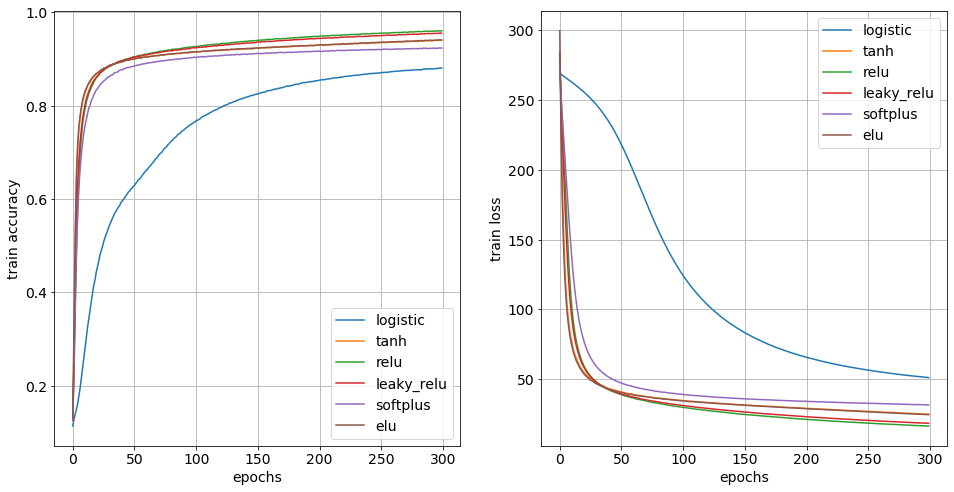

In [42]:
plt.figure(figsize=(16, 8))
plt.rcParams.update({'font.size': 14})

plt.subplot(121)
plt.plot(range(len(logistic_performance[0])), logistic_performance[0], label='logistic')
plt.plot(range(len(tanh_performance[0])), tanh_performance[0], label='tanh')
plt.plot(range(len(relu_performance[0])), relu_performance[0], label='relu')
plt.plot(range(len(lrelu_performance[0])), lrelu_performance[0], label='leaky_relu')
plt.plot(range(len(softplus_performance[0])), softplus_performance[0], label='softplus')
plt.plot(range(len(elu_performance[0])), elu_performance[0], label='elu')
plt.xlabel('epochs')
plt.ylabel('train accuracy')
plt.legend(loc='lower right')
plt.grid()

plt.subplot(122)
plt.plot(range(len(logistic_performance[1])), logistic_performance[1], label='logistic')
plt.plot(range(len(tanh_performance[1])), tanh_performance[1], label='tanh')
plt.plot(range(len(relu_performance[1])), relu_performance[1], label='relu')
plt.plot(range(len(lrelu_performance[1])), lrelu_performance[1], label='leaky_relu')
plt.plot(range(len(softplus_performance[1])), softplus_performance[1], label='softplus')
plt.plot(range(len(elu_performance[1])), elu_performance[1], label='elu')
plt.xlabel('epochs')
plt.ylabel('train loss')
plt.legend(loc='upper right')
plt.grid()

plt.savefig('mnist_performance-512.png', dpi=300)
plt.show()